In [1]:
!pip install tokenizers
import tensorflow as tf
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, Regex
import tokenizers
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.0 MB/s eta 0:00:0000:0100:01


2023-05-06 13:51:10.934823: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_name = 'deep_lstm'

# Load data

In [3]:
df = pd.read_csv('/home/user/files_for_research_Vova/processed_data.csv',\
                 usecols=['review_translate',
                                                            'dataset_name',
                                                            'rating',
                                                           'translated'])

In [4]:
df.head()

,review_translate,rating,dataset_name,translated
0,"Якісна пластмаса , переворот 360 градусвв",5.0,rozetka,False
1,За такі гроші це самий топ,5.0,rozetka,False
2,За такі гроші - просто супер ! Рекомендую .,5.0,rozetka,False
3,Виконує свою роботу не погано . але що ви хоті...,4.0,rozetka,False
4,Купляв на стару сістему як основний під віндов...,4.0,rozetka,False


In [5]:
subsets = pd.read_csv('/home/user/files_for_research_Vova/train_val_test_indices.csv')

In [6]:
subsets.head()

,index,split
0,0,train
1,1,test
2,2,train
3,3,train
4,4,train


In [7]:
subsets = subsets.merge(df[['dataset_name', 'translated']], left_on='index', right_index=True)

# Filter data

In [8]:
bad_indices = pd.read_csv('/home/user/files_for_research_Vova/files_to_check.csv')

In [9]:
subsets = subsets[~subsets.index.isin(bad_indices['id'].values)]

In [10]:
df = df[~df.index.isin(bad_indices['id'].values)]

In [11]:
df, subsets = df.reset_index().drop(columns='index'), subsets.reset_index().drop(columns='index')

# Load tokenizer

In [12]:
tokenizer = Tokenizer.from_file("/home/user/files_for_research_Vova/tokenizer_30k.json")


# Encode text

In [13]:
import seaborn as sns
import numpy as np

In [14]:
sns.set()

In [15]:
df['review_translate'] = df['review_translate'].str.lower()

In [16]:
df['encoded'] = tokenizer.encode_batch(df['review_translate'].values)

In [17]:
df['encoded'] = df['encoded'].apply(lambda x: x.ids)

/tmp/ipykernel_1/3749403729.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(df['encoded'].apply(len)))


<AxesSubplot: xlabel='encoded', ylabel='Density'>

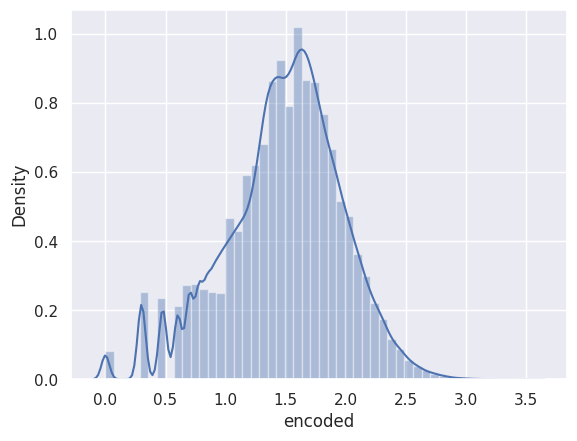

In [18]:
sns.distplot(np.log10(df['encoded'].apply(len)))

In [19]:
np.percentile(df['encoded'].apply(len), 99)

324.0

In [20]:
encoded_tokens = df['encoded'].values

In [21]:
from itertools import chain

In [22]:
padded_tokens = tf.keras.preprocessing.sequence\
.pad_sequences(encoded_tokens, maxlen=300, padding="post")


In [23]:
padded_tokens.shape

(655470, 300)

# Get labels and split data

In [24]:
mapping = dict([(i,c) for c,i in enumerate(df['rating'].unique())])

In [25]:
y = df['rating'].map(mapping).values

In [26]:
num_classes = len(set(y))

In [27]:
train_indices, val_indices, test_indices = subsets[subsets['split']=='train'].index.tolist(),\
subsets[subsets['split']=='val'].index.tolist(),\
subsets[subsets['split']=='test'].index.tolist()


In [28]:
train_y, val_y, test_y = y[train_indices], y[val_indices], y[test_indices]

In [29]:
train_x, val_x, test_x = padded_tokens[train_indices], padded_tokens[val_indices],\
padded_tokens[test_indices]

In [30]:
train_x.shape

(524346, 300)

# Create  model

In [45]:
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)
input_layer = tf.keras.layers.Input(shape=(300,), name='input')
word_embedding = tf.keras.layers.Embedding(input_dim=tokenizer.get_vocab_size(),
                                                   output_dim=300,
                                                   trainable=True,
                                           name='embedding',
                                           mask_zero=True
                                                   )
spat_dropout = tf.keras.layers.SpatialDropout1D(0.3, name='spatial_dropout')
layer_norm = tf.keras.layers.LayerNormalization(axis=-1)
lstm_1 = tf.keras.layers.LSTM(256, name='lstm1', return_sequences=True)
dropout_lstm = tf.keras.layers.Dropout(0.25)
lstm_2 = tf.keras.layers.LSTM(128, name='lstm2')

embedded = spat_dropout(word_embedding(input_layer))
lstm_lvl1 = lstm_1(embedded)
normed = layer_norm(dropout_lstm(lstm_lvl1))
lstm_lvl2 = lstm_2(normed)
x = tf.keras.layers.Dense(128, activation='relu', name='dense')(lstm_lvl2)
x = tf.keras.layers.Dropout(0.5, name='dense_dropout')(x)
output = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(x)
model = tf.keras.Model(input_layer, output)

# Compile model

In [46]:
model.compile(loss='sparse_categorical_crossentropy', \
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['acc'])

# Early stopping

In [33]:
import operator
class EarlyStopping:
    def __init__(self, tolerance=5, mode='min'):
        assert mode in ['min','max'], 'Mode should be min or max'
        self.mode = operator.lt if mode=='min' else operator.gt 
        self.tolerance = tolerance
        self.counter = 0
        self.early_stop = False
        self.extremum_value = None
        self.best_model = None
    
    @staticmethod
    def copy_model(model):
        copied_model = tf.keras.models.clone_model(model)
        copied_model.set_weights(model.get_weights())
        return copied_model
        
    def __call__(self, val, model):
        if self.extremum_value is None:
            self.extremum_value = val
            self.best_model = self.copy_model(model)
        else:
            if not self.mode(val, self.extremum_value):
                self.counter+=1
            else:
                self.extremum_value = val
                self.best_model = self.copy_model(model)
                self.counter = 0
        
        if self.counter==self.tolerance:
            self.early_stop=True

# Train model

In [34]:
from sklearn.metrics import f1_score

In [40]:
def evaluate_on_datasets(y_true, y_pred, split='val'):
    d = {}
    for dataset_name in subsets['dataset_name'].unique():
            idx = subsets[subsets['split']==split].copy()
            idx['index'] = list(range(idx.shape[0]))
            idx = idx[(idx['dataset_name']==dataset_name)]\
            ['index'].values.tolist()
            score = f1_score(y_true=y_true[idx], y_pred=y_pred[idx],
                                 average='macro')
            print(f'{split} f1 score for dataset {dataset_name} : {score}')
            d[f'{split}_f1_{dataset_name}'] = score
            
    for flag in [True, False]:
        idx = subsets[subsets['split']==split].copy()
        idx['index'] = list(range(idx.shape[0]))
        idx = idx[idx['translated']==flag]['index'].values.tolist()
        score = f1_score(y_true=y_true[idx], y_pred=y_pred[idx],
                                 average='macro')
        print(f'{split} f1 score for translated=={flag} : {score}')
        d[f'{split}_f1_translated=={flag}'] = score
    return d

In [41]:
def update_history(history, d):
    for key, value in d.items():
        res = history.get(key, [])
        res.append(value)
        history[key] = res

In [42]:
early_stopping = EarlyStopping(mode='max', tolerance=4)

In [43]:
def training_loop(model, train_x, train_y, val_x, val_y, epochs=10, batch_size=128,
                 shuffle=True):
    dict_history = {}
    for i in range(epochs):
        if shuffle and i==0:
            indices = np.arange(len(train_x))
            np.random.shuffle(indices)
            train_x = train_x[indices]
            train_y = train_y[indices]
            
        #train model
        history = model.fit(train_x, train_y, validation_data=(val_x, val_y), 
          epochs=1, batch_size=batch_size,
                           verbose=0, shuffle=False)
        train_loss, val_loss = history.history['loss'][-1], history.history['val_loss'][-1]
        
        #evaluate model
        train_prediction = np.argmax(model.predict(train_x, batch_size=batch_size), axis=-1)
        val_prediction = np.argmax(model.predict(val_x, batch_size=batch_size), axis=-1)
        train_f1 = f1_score(y_true=train_y, y_pred=train_prediction,
                           average='macro')
        val_f1 = f1_score(y_true=val_y, y_pred=val_prediction,
                         average='macro')
        
        #printing evaluation
        print(f'Epoch {i}')
        print(f'Overall train f1 : {train_f1}, overall val f1: {val_f1}')
        print(f'Train loss : {train_loss}, val loss: {val_loss}')
        d_train = evaluate_on_datasets(y_true=train_y, y_pred=train_prediction, split='train')
        d_val = evaluate_on_datasets(y_true=val_y, y_pred=val_prediction, split='val')
            
        if i!=epochs-1:
            print('-'*30)
            
        #save history
        update_history(dict_history, d_train)
        update_history(dict_history, d_val)
        update_history(dict_history, {'train_f1': train_f1})
        update_history(dict_history, {'val_f1': val_f1})
        update_history(dict_history, {'train_loss': train_loss})
        update_history(dict_history, {'val_loss': val_loss})
        #early stopping
        
        early_stopping(val_f1, model)
        if early_stopping.early_stop:
            print('Stopping early')
            model = early_stopping.best_model
            break
        
    return dict_history, model

In [47]:
dict_history, model = \
training_loop(model, train_x, train_y, 
              val_x, val_y, epochs=20, batch_size=2024, shuffle=True)

33/33 [==============================] - 2s 66ms/step
Epoch 0
Overall train f1 : 0.4960631761556984, overall val f1: 0.467470300851617
Train loss : 0.7517228126525879, val loss: 0.6440544128417969
train f1 score for dataset rozetka : 0.4869108693323045
train f1 score for dataset tripadvisor_hotels_ukraine : 0.5053915350202638
train f1 score for dataset tripadvisor_restaurants_ukraine : 0.5108072705177449
train f1 score for translated==True : 0.5002179801021348
train f1 score for translated==False : 0.47797065719222803
val f1 score for dataset rozetka : 0.414316804630357
val f1 score for dataset tripadvisor_hotels_ukraine : 0.5008804350506052
val f1 score for dataset tripadvisor_restaurants_ukraine : 0.5052870594440103
val f1 score for translated==True : 0.4739978916018746
val f1 score for translated==False : 0.4181229555870882
------------------------------
33/33 [==============================] - 2s 66ms/step
Epoch 1
Overall train f1 : 0.5726506460783649, overall val f1: 0.51238361099

In [48]:
dict_history

{'train_f1_rozetka': [0.4869108693323045,
  0.5595376822714255,
  0.5911726751174698,
  0.5458502235220389,
  0.5780896024411015,
  0.6600257484946228,
  0.6964004822981325,
  0.695249759322912,
  0.7263035991188644,
  0.745338878521017,
  0.7473236661755204],
 'train_f1_tripadvisor_hotels_ukraine': [0.5053915350202638,
  0.5787218275983127,
  0.6048960891864007,
  0.5534061156947443,
  0.5933627470173226,
  0.6728757059690038,
  0.712943602255912,
  0.7079814396621609,
  0.7458797347548691,
  0.7638415548906028,
  0.7701334016002628],
 'train_f1_tripadvisor_restaurants_ukraine': [0.5108072705177449,
  0.5967571115027466,
  0.6453198197497162,
  0.5875044138144303,
  0.6310033335998189,
  0.7344765765371007,
  0.7791271176457162,
  0.7779386310022327,
  0.8125177970578171,
  0.8306566244542462,
  0.8324209032246273],
 'train_f1_translated==True': [0.5002179801021348,
  0.578170239318647,
  0.6132345584492286,
  0.5613743558390356,
  0.5969602210367455,
  0.6838134020554161,
  0.7222680

# Show charts

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
def plot_history(dict_history, columns):
    plt.figure(figsize=(12,8))
    for i in columns:
        to_plot = dict_history[i]
        plt.plot(range(len(to_plot)), to_plot, 'o-')
    plt.xticks(range(len(to_plot)), range(len(to_plot)))
    plt.xlabel('Epochs')
    plt.legend(columns)

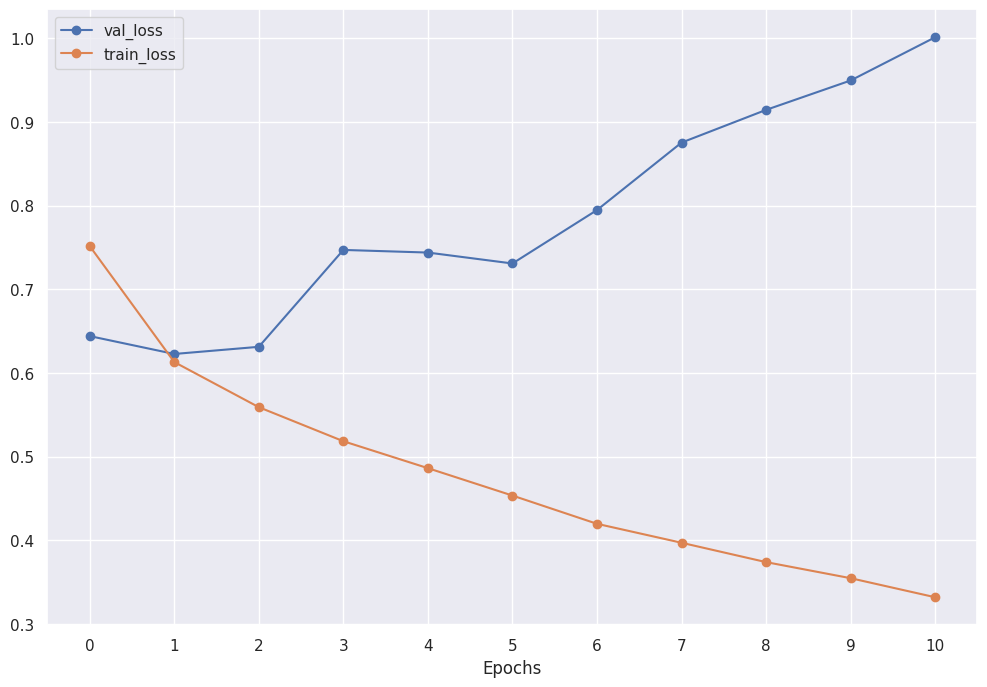

In [51]:
plot_history(dict_history, ['val_loss', 'train_loss'])

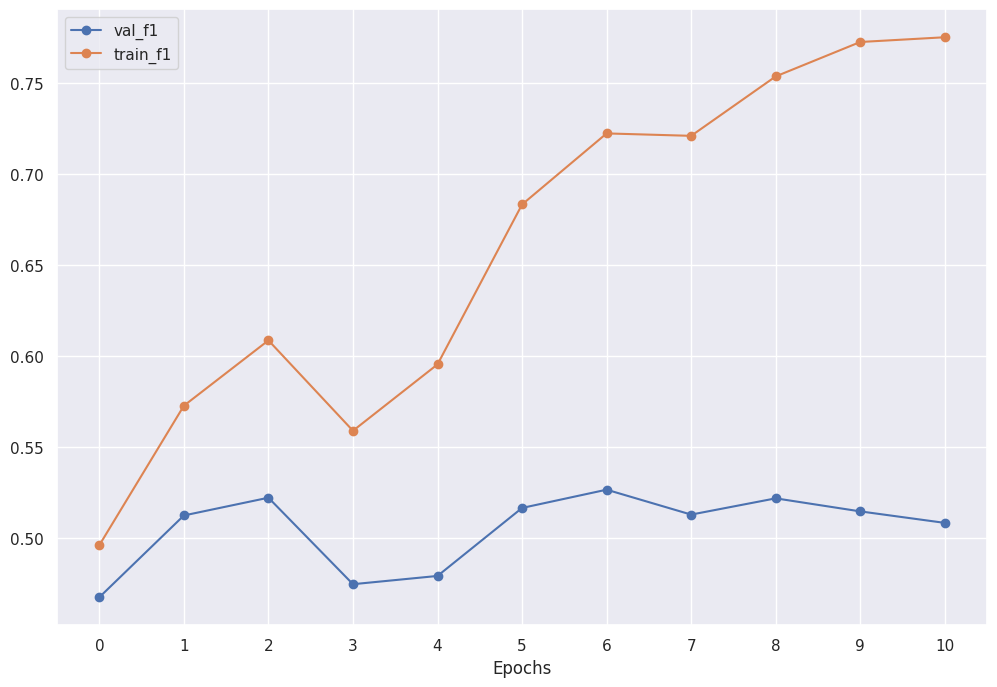

In [52]:
plot_history(dict_history, ['val_f1', 'train_f1'])

# Evaluate model

In [53]:
test_predictions = np.argmax(model.predict(test_x, batch_size=2024), axis=-1)

33/33 [==============================] - 5s 66ms/step


In [54]:
test_f1 = f1_score(y_true=test_y, y_pred=test_predictions,
                         average='macro')
print(f'Overall test f1-score : {test_f1}')

Overall test f1-score : 0.5282140922167834


In [55]:
test_results = evaluate_on_datasets(y_true=test_y, y_pred=test_predictions,split='test')
                     

test f1 score for dataset rozetka : 0.4918797702795163
test f1 score for dataset tripadvisor_hotels_ukraine : 0.548781584502241
test f1 score for dataset tripadvisor_restaurants_ukraine : 0.5540068479063447
test f1 score for translated==True : 0.532537063141008
test f1 score for translated==False : 0.49425845610886227


# Confusion matrix

In [56]:
inverse_mapping = dict([(v,k) for k,v in mapping.items()])

In [57]:
from sklearn.metrics import confusion_matrix

In [58]:
np.unique(test_y)

array([0, 1, 2, 3, 4])

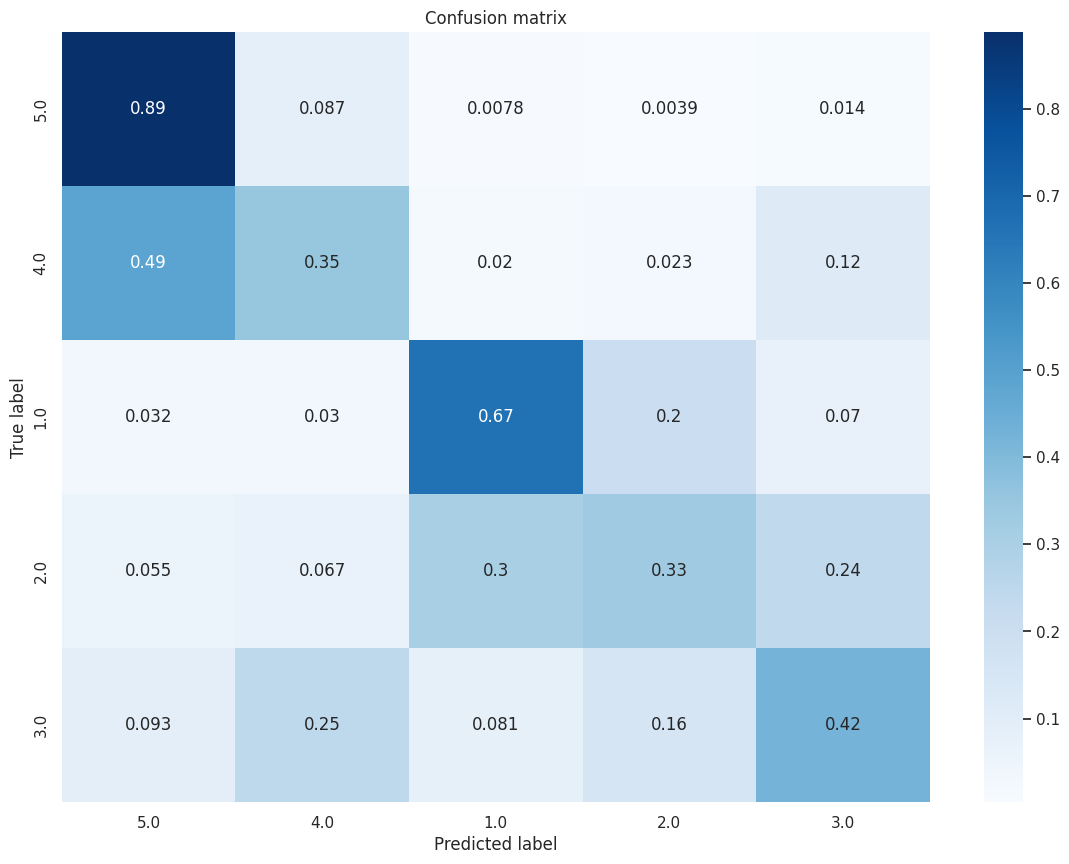

In [59]:
matrix = confusion_matrix(test_y, test_predictions)
matrix_scaled = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(14,10))
sns.heatmap(matrix_scaled, annot=True, cmap=plt.cm.Blues, xticklabels=[inverse_mapping[i] for i in np.unique(test_y)],\
            yticklabels=[inverse_mapping[i] for i in np.unique(test_y)])
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()

# Save history results

In [60]:
history = pd.DataFrame(dict_history)
for k,v in test_results.items():
    history[k] = v

In [61]:
history['model'] = model_name

In [62]:
history.to_csv("/home/user/jupyter_notebooks/Ukranian-SA/notebooks/training/training_results_filtered.csv", mode='w', index=None)

# Save model

In [63]:
model.save(f'/home/user/files_for_research_Vova/{model_name}.h5')